In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error

In [ ]:
raw_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Google Stock/GOOG.csv")
data_general = pd.DataFrame(raw_data)
data = data_general[['close']] # Using stock value at the end of each day

timesteps = 60 # Amount of days the models looks into the past for each step

def create_sequences(data, timesteps):
    x, y = [], []
    for i in range(timesteps, len(data)):
        x.append(data[i-timesteps:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

In [ ]:
data_general.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


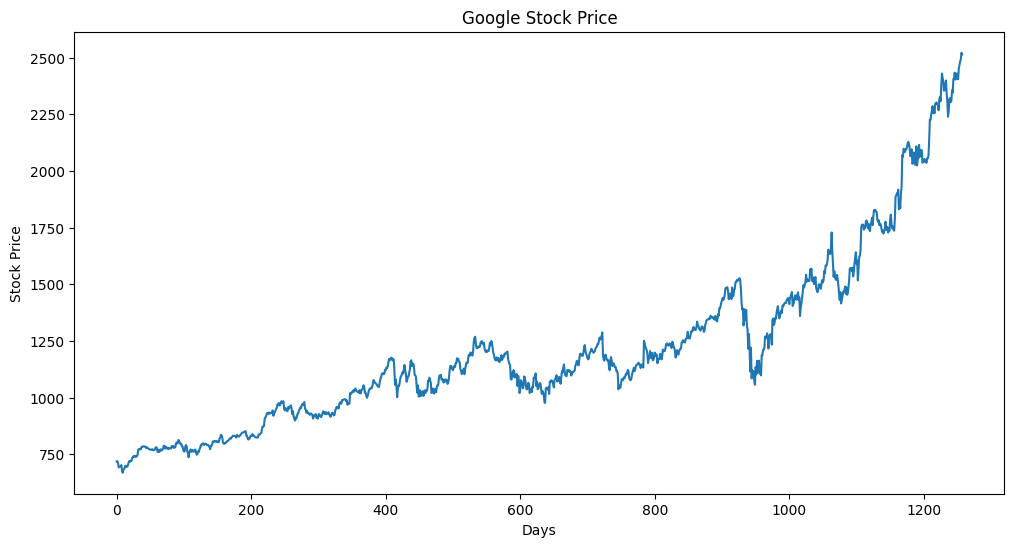

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data)
plt.title('Google Stock Price')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.values)

In [ ]:
train_size = int(len(data_scaled) * 0.8) # 80% training model
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size - timesteps:]

x_train, y_train = create_sequences(train_data, timesteps)
x_test, y_test = create_sequences(test_data, timesteps)

In [ ]:
x_train, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32) # Training and testing tensors
x_test, y_test = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

x_train = x_train.unsqueeze(-1)
x_test = x_test.unsqueeze(-1)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output of the last timestep
        return out
model1 = LSTMModel(input_size=1, hidden_size=50, num_layers=2)
model2 = LSTMModel(input_size=1, hidden_size=100, num_layers=3) # More complex with higher hidden_size (More neurons)
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
def train_model(model, optimizer, x_train, y_train, epochs=50, batch_size=32):
    dataset = TensorDataset(x_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    losses = []
    maes = []

    for epoch in range(epochs):
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        # The formula for mean absolute error is the sum of the absolute value of all of the differences in each predictions divided by the number of predictions
        maes.append(mean_absolute_error(y_batch.detach().numpy(), y_pred.detach().numpy()))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, MAE: {maes[-1]}")
    return losses, maes
losses1, maes1 = train_model(model1, optimizer1, x_train, y_train)
losses2, maes2 = train_model(model2, optimizer2, x_train, y_train)

Epoch 1/50, Loss: 0.009410997852683067, MAE: 0.07126371562480927
Epoch 2/50, Loss: 0.0006759268580935895, MAE: 0.02169402688741684
Epoch 3/50, Loss: 0.0002796233748085797, MAE: 0.013030054047703743
Epoch 4/50, Loss: 0.000306163594359532, MAE: 0.013310188427567482
Epoch 5/50, Loss: 0.0002642094041220844, MAE: 0.011792970821261406
Epoch 6/50, Loss: 0.00032629407360218465, MAE: 0.012464959174394608
Epoch 7/50, Loss: 0.00027863631839863956, MAE: 0.013451134786009789
Epoch 8/50, Loss: 0.00021526971249841154, MAE: 0.011438794434070587
Epoch 9/50, Loss: 0.00035051710437983274, MAE: 0.0134033327922225
Epoch 10/50, Loss: 0.00014268417726270854, MAE: 0.010054920800030231
Epoch 11/50, Loss: 0.0005048571620136499, MAE: 0.019260885193943977
Epoch 12/50, Loss: 0.000694802962243557, MAE: 0.014945651404559612
Epoch 13/50, Loss: 0.0001852095010690391, MAE: 0.010549708269536495
Epoch 14/50, Loss: 0.00029676512349396944, MAE: 0.012162331491708755
Epoch 15/50, Loss: 0.00022718094987794757, MAE: 0.01073325

In [ ]:
def predict(model, X):
    with torch.no_grad():
        return model(X).numpy()

y_pred1 = predict(model1, x_test)
y_pred2 = predict(model2, x_test)

In [ ]:
y_test_actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
y_pred1_actual = scaler.inverse_transform(y_pred1)
y_pred2_actual = scaler.inverse_transform(y_pred2)

In [ ]:
mse1 = np.mean((y_test_actual - y_pred1_actual) ** 2) # Mean squared error
mse2 = np.mean((y_test_actual - y_pred2_actual) ** 2)

print(f"Model 1 MSE: {mse1}")
print(f"Model 2 MSE: {mse2}")

Model 1 MSE: 7259.7607421875
Model 2 MSE: 4345.1640625


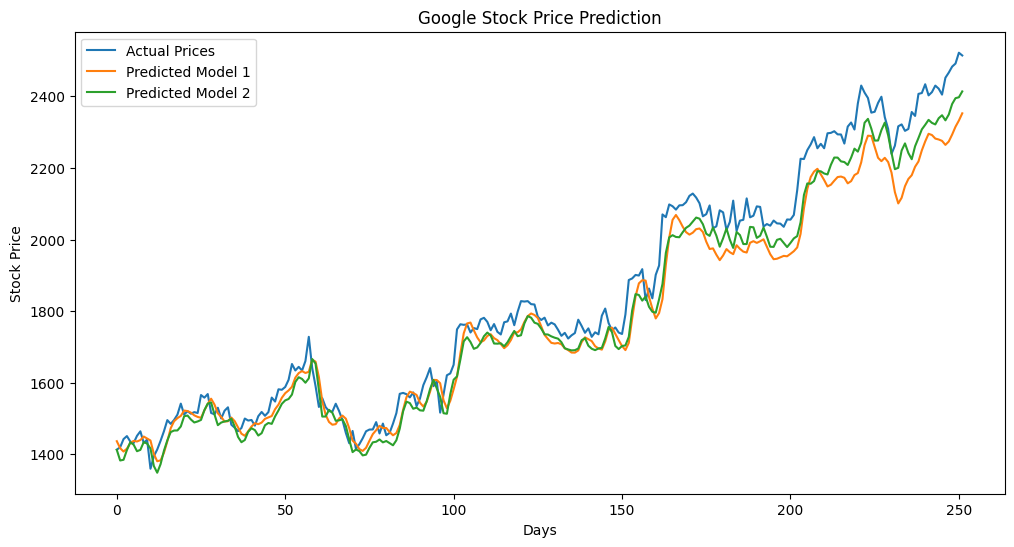

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Prices') # Testing data is from the last 250 days
plt.plot(y_pred1_actual, label='Predicted Model 1')
plt.plot(y_pred2_actual, label='Predicted Model 2')
plt.legend()
plt.title('Google Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()